Context
You are an analyst at a large online store. Together with the marketing department, you have compiled a list of hypotheses that could help increase revenue. You need to prioritize these hypotheses, launch an A/B test, and analyze the results.

/datasets/orders_us.csv

transactionId: order identifier.
visitorId: identifier of the user who placed the order.
date: date of the order.
revenue: revenue from the order.
group: the A/B test group to which the user belongs.
/datasets/visits_us.csv

date: the date.
group: A/B test group.
visits: the number of visits on the specified date in the specified A/B test group.
Be sure to preprocess the data. There may be errors in the original datasets; for example, some visitors may have entered both group A and group B.

Part 1. Prioritizing hypotheses
The file hypotheses_us.csv contains nine hypotheses on how to increase revenue for an online store, with Reach, Impact, Confidence, and Effort specified for each one.

The exercise consists of:

1) Applying the ICE framework to prioritize hypotheses. Sort them in descending order of priority.
2) Applying the RICE framework to prioritize hypotheses. Sort them in descending order of priority.
3) Show how the prioritization of hypotheses changes when you use RICE instead of ICE. Provide an explanation for the changes.

## Libraries and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from datetime import timedelta
sns.set_style('whitegrid')
np.random.seed(42)

orders_df = pd.read_csv('/datasets/orders_us.csv', sep=',')

print(orders_df.head(5))
print(orders_df.columns)

   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     30.4     B
1     2804400009  3642806036  2019-08-15     15.2     B
2     2961555356  4069496402  2019-08-15     10.2     A
3     3797467345  1196621759  2019-08-15    155.1     B
4     2282983706  2322279887  2019-08-15     40.5     B
Index(['transactionId', 'visitorId', 'date', 'revenue', 'group'], dtype='object')


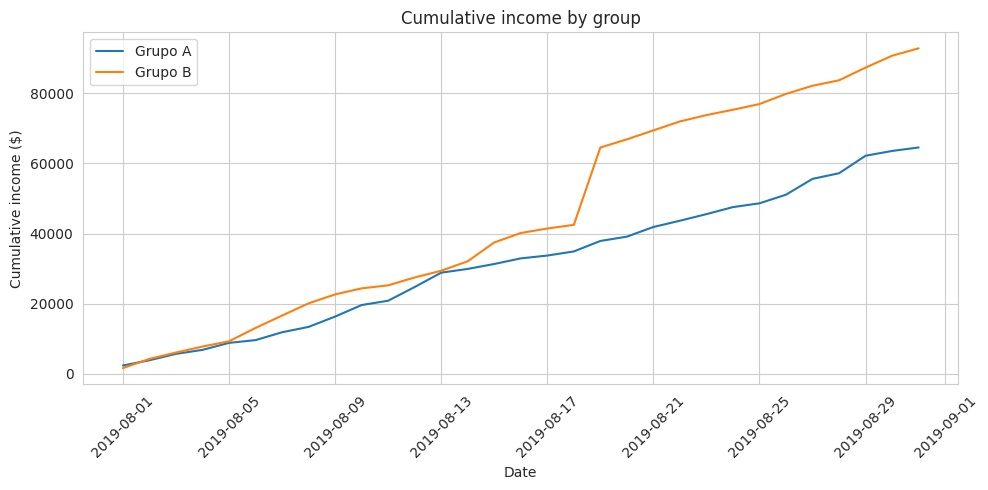

In [2]:
# Preprocessing: date column to datetime
orders_df['date'] = pd.to_datetime(orders_df['date'])

# Cumulative income
cumulative_revenue = (
    orders_df.groupby(['group', 'date'])['revenue'].sum().groupby(level=0).cumsum().reset_index())

plt.figure(figsize=(10,5))
for grp in ['A', 'B']:
    grp_data = cumulative_revenue[cumulative_revenue['group']==grp]
    plt.plot(grp_data['date'], grp_data['revenue'], label=f'Grupo {grp}')
plt.title('Cumulative income by group')
plt.xlabel('Date')
plt.ylabel('Cumulative income ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Cumulative income by group
Comparing groups A and B according to the graph, it can be seen that during the period evaluated, group B generates more revenue than group A. There are two points at which the revenue is similar (August 1, 2019, and August 13, 2019). The significant growth in group B's revenue from August 17, 2019, onwards is striking.

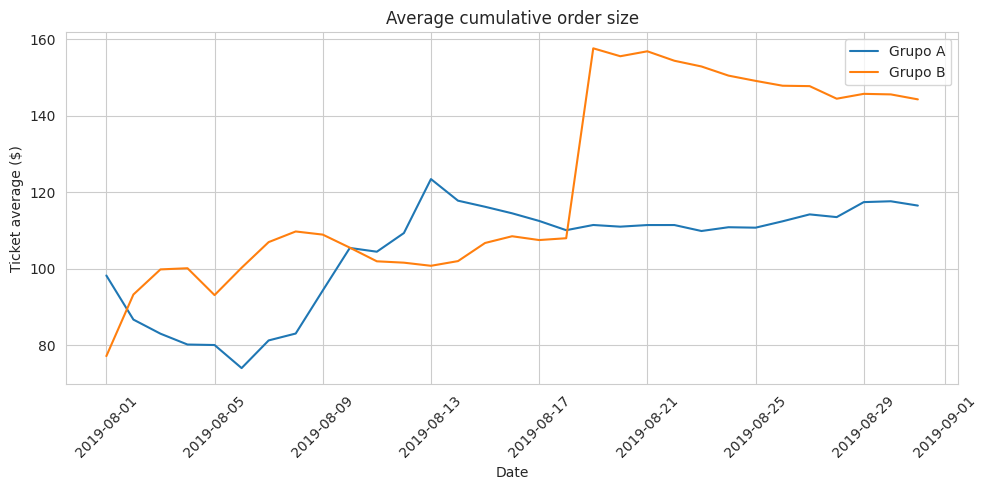

In [3]:
# Daily average revenue per group
avg_order = orders_df.groupby(['group', 'date'])['revenue'].mean().reset_index()

# Calculate cumulative average in a simple way
avg_order['cummean'] = avg_order.groupby('group')['revenue'].cumsum() / avg_order.groupby('group').cumcount().add(1)

# Graph
plt.figure(figsize=(10,5))
for grp in ['A', 'B']:
    data = avg_order[avg_order['group'] == grp]
    plt.plot(data['date'], data['cummean'], label=f'Grupo {grp}')

plt.title('Average cumulative order size')
plt.xlabel('Date')
plt.ylabel('Ticket average ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

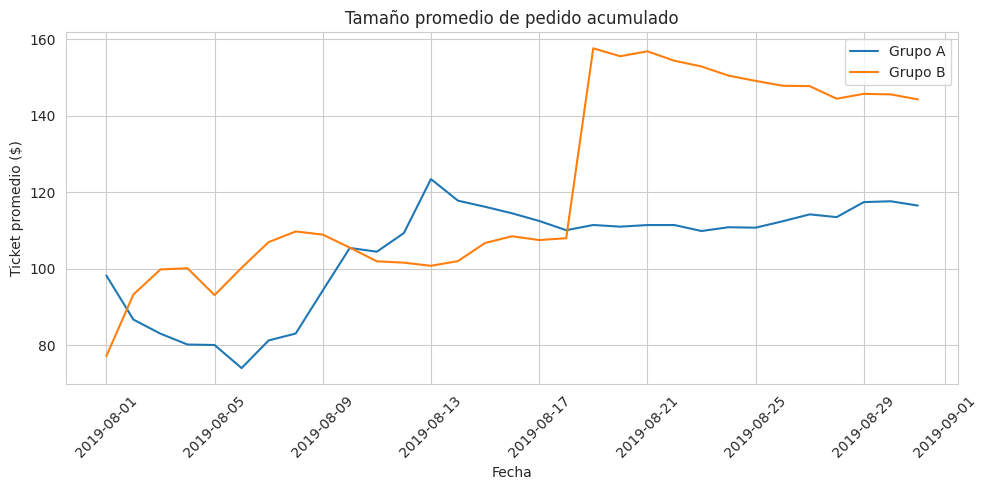

In [4]:
# Calculate cumulative average in a simple way
avg_order['cummean'] = avg_order.groupby('group')['revenue'].cumsum() / avg_order.groupby('group').cumcount().add(1)

# Graph
plt.figure(figsize=(10,5))
for grp in ['A', 'B']:
    data = avg_order[avg_order['group'] == grp]
    plt.plot(data['date'], data['cummean'], label=f'Grupo {grp}')

plt.title('Tamaño promedio de pedido acumulado')
plt.xlabel('Fecha')
plt.ylabel('Ticket promedio ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It can be seen that the cumulative average order size varies over time. From August 1, 2019, to August 9, 2019, group B reflects a larger size. Then, group A becomes larger between August 9, 2019, and August 17, 2019. From there, Group B grows significantly, consistent with the previous graph.

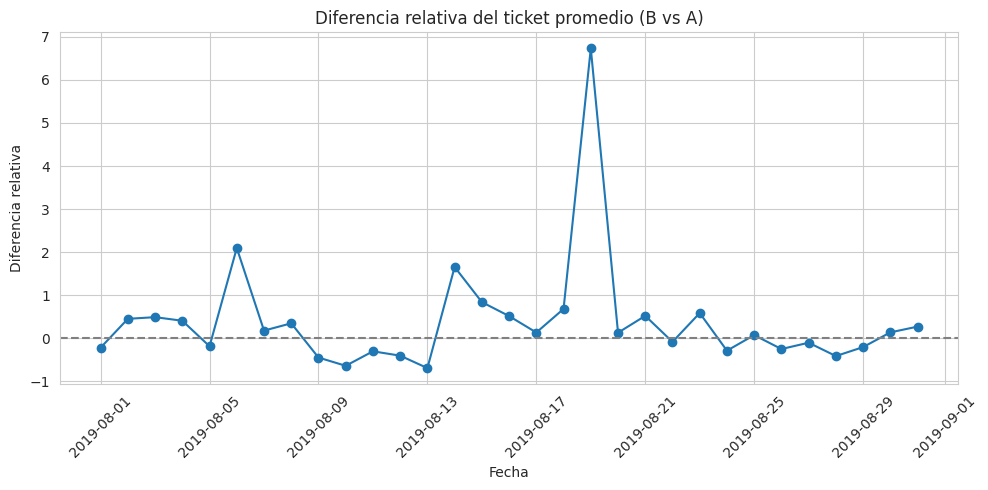

In [5]:
merged_avg = (
    avg_order.pivot(index='date', columns='group', values='revenue')
    .reset_index()
)
merged_avg['rel_diff'] = (merged_avg['B'] - merged_avg['A']) / merged_avg['A']

plt.figure(figsize=(10,5))
plt.plot(merged_avg['date'], merged_avg['rel_diff'], marker='o')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Diferencia relativa del ticket promedio (B vs A)')
plt.xlabel('Fecha')
plt.ylabel('Diferencia relativa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In those sections of the graph with a positive difference, group B has a higher cumulative average order size than group A. In those sections where the difference is negative (below zero), the average order size of group A is higher.

Conversion rate

In [6]:
visits_df = pd.read_csv('/datasets/visits_us.csv', sep=',')
visits_df['date'] = pd.to_datetime(visits_df['date'])


print(visits_df.head(5))
print(visits_df.columns)

        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756
Index(['date', 'group', 'visits'], dtype='object')


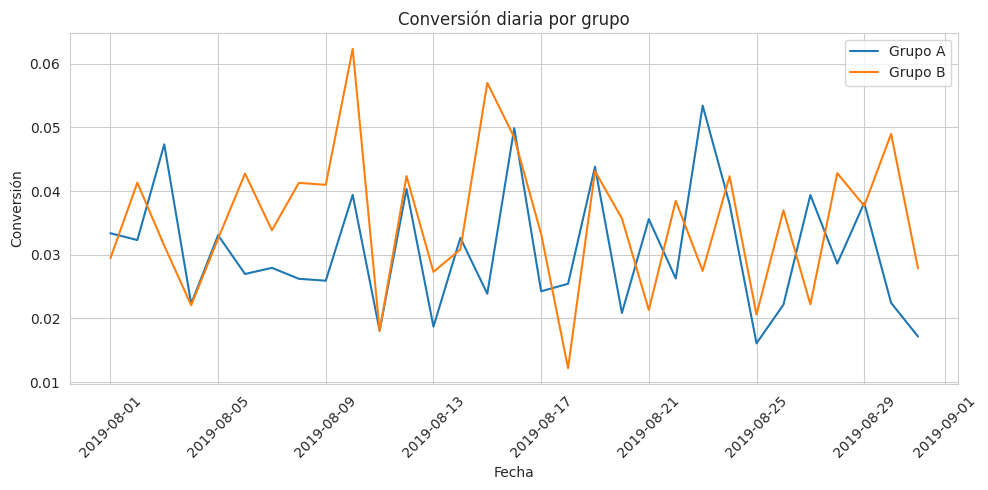

In [7]:
# Orders per day and group
orders_per_day = orders_df.groupby(['group', 'date']).agg({'transactionId':'nunique'}).reset_index()
orders_per_day.rename(columns={'transactionId':'orders'}, inplace=True)

# connect with visits
daily = pd.merge(visits_df, orders_per_day, on=['group','date'], how='left').fillna(0)
daily['conversion'] = daily['orders'] / daily['visits']

plt.figure(figsize=(10,5))
for grp in ['A','B']:
    grp_data = daily[daily['group']==grp]
    plt.plot(grp_data['date'], grp_data['conversion'], label=f'Grupo {grp}')
plt.title('Conversión diaria por grupo')
plt.xlabel('Fecha')
plt.ylabel('Conversión')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1) In general terms, a similar pattern of behavior can be observed in the conversion rate of both groups, with the curves tending to have peaks and troughs at similar times.
2) Group B reflects a higher conversion rate at various points in time, giving the impression that, in general terms, the conversion rate for B is higher.
3) There are four points at which the conversion rate for A is higher.

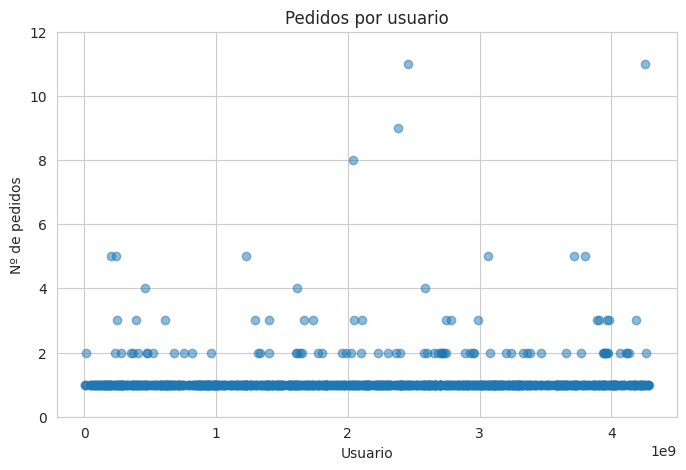

In [8]:
orders_per_user = orders_df.groupby('visitorId').agg({'transactionId':'nunique'}).reset_index()
orders_per_user.rename(columns={'transactionId':'orders'}, inplace=True)

plt.figure(figsize=(8,5))
plt.scatter(orders_per_user['visitorId'], orders_per_user['orders'], alpha=0.5)
plt.title('Pedidos por usuario')
plt.xlabel('Usuario')
plt.ylabel('Nº de pedidos')
plt.ylim(0, orders_per_user['orders'].max()+1)
plt.show()

1) Most users place one order.
2) There is a portion of users (smaller than the first group) who place two orders.
3) There is a smaller number of users who place between three and five orders.
4) There are outliers who place more than eight orders.

# 95th and 99th percentiles 

In [9]:
q95_orders = np.percentile(orders_per_user['orders'], 95)
q99_orders = np.percentile(orders_per_user['orders'], 99)
print(f'Percentil 95: {q95_orders}, Percentil 99: {q99_orders}')

Percentil 95: 2.0, Percentil 99: 4.0


1) 95% of users placed 2 orders or fewer, while the remaining 5% placed more than 2 orders.
2) 99% of users placed 4 orders or fewer, while the remaining 1% placed more than 4 orders.
3) Data above the 99th percentile is an anomaly.

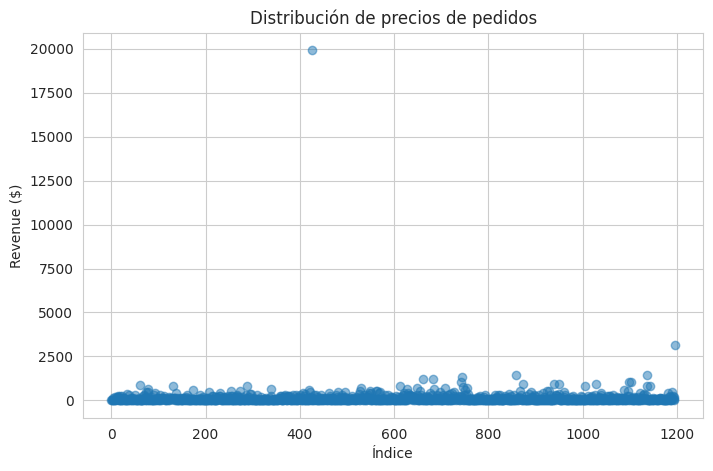

In [10]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(orders_df)), orders_df['revenue'], alpha=0.5)
plt.title('Distribución de precios de pedidos')
plt.xlabel('Índice')
plt.ylabel('Revenue ($)')
plt.show()

1) Most items are priced below $1,000.
2) There is a concentration of product prices.
3) There are some products with above-average prices, which stand out in the graph but are in the minority.
4) There are two outliers.

In [11]:
q95_rev = np.percentile(orders_df['revenue'], 95)
q99_rev = np.percentile(orders_df['revenue'], 99)
print(f'Percentil 95: {q95_rev:.2f}, Percentil 99: {q99_rev:.2f}')

Percentil 95: 435.54, Percentil 99: 900.90


1) 95% of products are priced below 435.54, the remaining 5% are priced above this value.
2) 99% of products are priced below 900.90, the remaining 1% are priced above this value.
3) Data above the 99th percentile is considered an anomaly.

# statistical significance of the difference in conversion

In [12]:
conversions = daily.groupby('group').agg({'orders':'sum', 'visits':'sum'})
success = conversions['orders']
trials = conversions['visits']
stat, pval = proportions_ztest(success, trials)
alpha = 0.05
print(f'Z-statistic: {stat:.4f}, p-valor: {pval:.4f}')

if (pval < alpha):
    print("Reject the null hypothesis: there is a significant difference in conversion between the groups.")
else:
    print("The null hypothesis could not be rejected: there is no reason to believe that the conversion between groups is different.")

Z-statistic: -2.2700, p-valor: 0.0232
Reject the null hypothesis: there is a significant difference in conversion between the groups.


1) There is a difference in conversion between the groups.

# difference in average order size between groups using raw data.

In [13]:
a_revenue = orders_df[orders_df['group']=='A']['revenue']
b_revenue = orders_df[orders_df['group']=='B']['revenue']
u_stat, pval_rev = stats.mannwhitneyu(a_revenue, b_revenue, alternative='two-sided')

alpha = 0.05
print(f'U-statistic: {u_stat}, p-valor: {pval_rev:.4f}')
if (pval_rev < alpha):
    print("Reject the null hypothesis: there is a significant difference in the average size between the groups.")
else:
    print("The null hypothesis could not be rejected: there is no reason to believe that the average size between the groups is different.")

U-statistic: 175872.5, p-valor: 0.6915
The null hypothesis could not be rejected: there is no reason to believe that the average size between the groups is different.


In [14]:
# Thresholds
orders_threshold = q99_orders
revenue_threshold = q99_rev

# Extract users with anomalous orders
abnormal_users = orders_per_user[orders_per_user['orders'] > orders_threshold]['visitorId']
filtered_orders = orders_df[~orders_df['visitorId'].isin(abnormal_users) & (orders_df['revenue'] <= revenue_threshold)]

# Recalculate daily figures with filtered data
orders_per_day_f = filtered_orders.groupby(['group', 'date']).agg({'transactionId':'nunique'}).reset_index()
orders_per_day_f.rename(columns={'transactionId':'orders'}, inplace=True)
daily_f = pd.merge(visits_df, orders_per_day_f, on=['group','date'], how='left').fillna(0)
daily_f['conversion'] = daily_f['orders'] / daily_f['visits']

conversions_f = daily_f.groupby('group').agg({'orders':'sum', 'visits':'sum'})
stat_f, pval_f = proportions_ztest(conversions_f['orders'], conversions_f['visits'])
print(f'Conversión filtrada - z: {stat_f:.4f}, p-valor: {pval_f:.4f}')
if (pval_f < alpha):
    print("Reject the null hypothesis: there is a significant difference in conversion between the groups.")
else:
    print("The null hypothesis could not be rejected: there is no reason to believe that the conversion between groups is different.")

print()
a_rev_f = filtered_orders[filtered_orders['group']=='A']['revenue']
b_rev_f = filtered_orders[filtered_orders['group']=='B']['revenue']
u_stat_f, pval_rev_f = stats.mannwhitneyu(a_rev_f, b_rev_f, alternative='two-sided')
print(f'Ticket promedio filtrado - U: {u_stat_f}, p-valor: {pval_rev_f:.4f}')
if (pval_rev_f < alpha):
    print("Reject the null hypothesis: there is a significant difference in the average size between the groups.")
else:
    print("The null hypothesis could not be rejected: there is no reason to believe that the average size between the groups is different.")

Conversión filtrada - z: -2.4513, p-valor: 0.0142
Reject the null hypothesis: there is a significant difference in conversion between the groups.

Ticket promedio filtrado - U: 154307.0, p-valor: 0.9332
The null hypothesis could not be rejected: there is no reason to believe that the average size between the groups is different.


Final decision on the test
It is recommended to continue with the test. Although there is a difference in conversion between groups, there is no difference in the average order size.